In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf


2022-06-03 14:06:52.891485: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-03 14:06:52.891532: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import read_and_visualize_data as rnv

df = rnv.read_and_visualize_data_as_df("dataset_HDF5_testtest", ["Liquid X-Velocity [m_per_y]", "Liquid Y-Velocity [m_per_y]",
       "Liquid Z-Velocity [m_per_y]"], plot_bool=False)

100%|██████████| 7/7 [00:00<00:00, 107.72it/s]


**Preprocessing**

In [3]:
## shuffle data along "RUN_"-axis
# is already shuffled from reading-order but whatever
df_shuffled = df.sample(frac=1)

## split data into test and training data
train_size_percent = 0.8
train_size_abs = int(train_size_percent * df.shape[0]) # cuts instead of rounds

df_train = df_shuffled[:train_size_abs]
df_test = df_shuffled[train_size_abs:]

## data normalizing:
# prep data: normalize all input values (vel/pressure) and all output values (temp/vel?), each to its own min,max, std

# scaler-function for a row(=index) in the dataset
def get_max_min(array):
    return np.max(array), np.min(array)

def scale_data_row(data, column, desired_max = 1, desired_min = -1):
    max_list = []
    min_list = []
    for row in data.index:
        max_temp, min_temp = get_max_min(data.at[row, column])
        max_list.append(max_temp)
        min_list.append(min_temp)
    
    max_data = np.max(max_list)
    min_data = np.min(min_list) 
    for row in data.index:
        data_std = (data.at[row,column] - min_data) / (max_data - min_data)
        data.at[row, column] = data_std * (desired_max - desired_min) + desired_min
        # if values all the same in field, then they will be set to nan in the prev step, set them to zero instead:
        # NOT TESTED YET
        zero_gradient = data.at[row,column] == np.nan
        data.at[row, column][zero_gradient] = 0
    return data

def scale_data_id(data, column="Material_ID"):
    for row in data.index:
        injection = data.at[row, column] == 2
        extraction = data.at[row,column] == 3
        nothing = data.at[row, column] == 1
        data.at[row, column][injection] = 1
        data.at[row, column][extraction] = -1
        data.at[row, column][nothing] = 0
        return data

def scale_data(data):
    for column in data.columns:
        if column == "Material_ID":
            data = scale_data_id(data)
        else:
            data = scale_data_row(data, column)
    return data

df_train = scale_data(df_train)
df_test = scale_data(df_test)


# just for manuel checking the values
#for column in df_test.columns:
#    for row in df_test.index:
#        print(column, row, np.min(df_test.at[row, column]), np.max(df_test.at[row, column]), np.std(df_test.at[row, column]))
#for column in df_train.columns:
#    for row in df_train.index:
#        print(column, row, np.min(df_train.at[row, column]), np.max(df_train.at[row, column]), np.std(df_train.at[row, column]))

In [4]:
## split data into input and labels
df_train_in = pd.DataFrame(df_train[["Liquid X-Velocity [m_per_y]", "Liquid Y-Velocity [m_per_y]",
       "Liquid Z-Velocity [m_per_y]","Material_ID"]])
df_train_labels = pd.DataFrame(df_train["Temperature [C]"])
df_test_in = pd.DataFrame(df_test[["Liquid X-Velocity [m_per_y]", "Liquid Y-Velocity [m_per_y]",
       "Liquid Z-Velocity [m_per_y]","Material_ID"]])
df_test_labels = pd.DataFrame(df_test["Temperature [C]"])

In [5]:
## parameters
#shuffle_buffer_size = 10
#
### seperate dataset into input data and corresponding output labels
#data_in = {}
#data_labels = {}
#
#data_in['Liquid_Pressure [Pa]'] = data['Liquid_Pressure [Pa]'] #maybe for help in beginning: 'Liquid X-Velocity [m_per_y]', 'Liquid Y-Velocity [m_per_y]', 'Liquid Z-Velocity [m_per_y]']
#data_in['Material_ID'] = data['Material_ID']
#data_labels['Temperature [C]'] = data['Temperature [C]']
#
## create dataset for tf, slice along first dimension: datapoint
## one element := one datapoint (RUN_XYZ); each datapoint is a dictionnary with [0]: input keys="physical properties" (p,pos_hp), values =(x,y,z)-component, [1]:  output keys="physical properties" (T), values =(x,y,z)-component
#tf_data = tf.data.Dataset.from_tensor_slices((data_in, data_labels))
##print(tf_data.element_spec)
#print([elem[0]['Liquid_Pressure [Pa]'][0,0,0].numpy() for elem in tf_data])
#
## shuffle the data
#tf_data = tf_data.shuffle(shuffle_buffer_size)
#print([elem[0]['Liquid_Pressure [Pa]'][0,0,0].numpy() for elem in tf_data])
#
##np.random.seed(seed=1) # TODO just for programming and varification purposes at this point, delete later!

In [6]:
## mnist example to figure out dimensions, format etc
#temp = tf.keras.datasets.mnist.load_data(
#    path='mnist.npz'
#)
#for i in (0,1):
#    for j in (0,1):
#        print(np.shape(temp[i][j]))

In [7]:
def reshape(data):
    data_reshape = []
    for row in data.index:
        temp = []
        for column in data.columns:
            temp.append(data.at[row, column])
        data_reshape.append(temp)

    #print(data.columns, data.index)
    data_reshape = np.moveaxis(data_reshape, 1, 4)
    #print(np.shape(data_reshape))
    return data_reshape

data_train_in =reshape(df_train_in)
data_train_labels =reshape(df_train_labels)
data_test_in =reshape(df_test_in)
data_test_labels =reshape(df_test_labels)


# make tuples for input into tf.data.Dataset
data_train = (data_train_in, data_train_labels)
data_test = (data_test_in, data_test_labels)
data = (data_train, data_test)

**FCN model definition**

adapted from https://github.com/himanshurawlani/fully_convolutional_network.git
made it 3D

In [8]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation, MaxPool3D, Dense, GlobalAveragePooling3D, ReLU, LeakyReLU, UpSampling3D
from tensorflow.keras.utils import to_categorical

In [9]:
%load_ext tensorboard

In [10]:
#print(np.shape(data))
tf_dataloader_train = tf.data.Dataset.from_tensors(data_train)
tf_dataloader_test = tf.data.Dataset.from_tensors(data_test)
# data format: number of sample, x,y,z-dimension, physical property/"channel"

batch_size = 2
# Augment the on the fly during training.
tf_data_train = (
    tf_dataloader_train#.shuffle(len(x_train))
    #.map(train_preprocessing)
    .batch(batch_size)
    #.prefetch(2)
)

tf_data_test = (
    tf_dataloader_test
    .batch(batch_size)
    #.prefetch(2)#
)

2022-06-03 14:18:20.122769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-03 14:18:20.122811: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-03 14:18:20.122838: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lapsgs18): /proc/driver/nvidia/version does not exist
2022-06-03 14:18:20.124197: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
list(tf_dataloader_train)
#TODO SIMULATION: start heatpump after first time step to get a velocity field without noise - KINDA DONE...? velocity field does not look very reasonable

2022-06-03 14:19:00.254033: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


[(<tf.Tensor: shape=(4, 18, 146, 14, 4), dtype=float64, numpy=
  array([[[[[ 0.83610501,  0.49729698, -0.99590225,  0.        ],
            [ 0.83444905,  0.49723266, -0.99689913,  0.        ],
            [ 0.83444878,  0.49718694, -0.99968733,  0.        ],
            ...,
            [ 0.83279084,  0.49673021, -0.99903273,  0.        ],
            [ 0.83279059,  0.49667982, -0.99624295,  0.        ],
            [ 0.83072102,  0.49661548, -0.99655779,  0.        ]],
  
           [[ 0.84935057,  0.49729354, -0.99755463,  0.        ],
            [ 0.84769446,  0.49723864, -0.99779083,  0.        ],
            [ 0.84769404,  0.49718826, -0.99855742,  0.        ],
            ...,
            [ 0.84520706,  0.49672719, -0.99838258,  0.        ],
            [ 0.8447928 ,  0.49667556, -0.99761556,  0.        ],
            [ 0.8427231 ,  0.49662064, -0.99773088,  0.        ]],
  
           [[ 0.86094043,  0.49729257, -0.99819239,  0.        ],
            [ 0.86093987,  0.49724008

In [14]:
## model try super simple
#padding = (kernel_length - 1)/2 #"same" vs "valid"
#stride = 0, otherwise decrease input size
dilation = 2
channel_exponent = 2
channels = int(2**channel_exponent + 0.5)
input_shape = (18, 146, 14, 4)
step = Sequential([
    Conv3D(8,3,padding = "same"),
    LeakyReLU(),
])
model = Sequential(
    [
    Conv3D(filters = 8,kernel_size = 9,padding = "same"),
    ReLU(),
    Conv3D(filters = 8,kernel_size = 7,padding = "same"),
    ReLU(),
    Conv3D(filters = 8,kernel_size = 5,padding = "same"),
    ReLU(),
    Conv3D(filters = 16,kernel_size = 3,padding = "same"),
    ReLU(),
    #Conv3D(channels, kernel_size=3, strides=(1,1,1), padding='same', dilation_rate=dilation, input_shape=input_shape),
    #Conv3D(filters=channels, kernel_size=4, padding="same", dilation_rate=1),
    #ReLU(),
    #Conv3D(filters=channels*2, kernel_size=4, padding="same", dilation_rate=dilation),
    #ReLU(),
    #Conv3D(filters=channels*4, kernel_size=4, padding="same", dilation_rate=dilation),
    #ReLU(),
    Conv3D(filters=1, kernel_size=1, padding="same"),
    ])

#model.summary()

In [15]:
# Compile model.
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["mse"],
)

log_dir = "log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    tf_dataloader_train,
    validation_data=tf_dataloader_test,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[tensorflow_callback]
)



Epoch 1/100


2022-06-03 14:19:24.854212: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31788288 exceeds 10% of free system memory.
2022-06-03 14:19:24.856435: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31788288 exceeds 10% of free system memory.
2022-06-03 14:19:25.239859: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 147168000 exceeds 10% of free system memory.
2022-06-03 14:19:25.242156: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 147168000 exceeds 10% of free system memory.


1/1 - 13s - loss: 1.0357 - mse: 1.0357 - val_loss: 0.9954 - val_mse: 0.9954 - 13s/epoch - 13s/step
Epoch 2/100


2022-06-03 14:19:35.525996: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31788288 exceeds 10% of free system memory.
2022-06-03 14:19:35.526064: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31788288 exceeds 10% of free system memory.


1/1 - 10s - loss: 0.9301 - mse: 0.9301 - val_loss: 0.9600 - val_mse: 0.9600 - 10s/epoch - 10s/step
Epoch 3/100
1/1 - 8s - loss: 0.8568 - mse: 0.8568 - val_loss: 0.9249 - val_mse: 0.9249 - 8s/epoch - 8s/step
Epoch 4/100
1/1 - 7s - loss: 0.7677 - mse: 0.7677 - val_loss: 0.8795 - val_mse: 0.8795 - 7s/epoch - 7s/step
Epoch 5/100
1/1 - 8s - loss: 0.6568 - mse: 0.6568 - val_loss: 0.8184 - val_mse: 0.8184 - 8s/epoch - 8s/step
Epoch 6/100
1/1 - 8s - loss: 0.5319 - mse: 0.5319 - val_loss: 0.7401 - val_mse: 0.7401 - 8s/epoch - 8s/step
Epoch 7/100
1/1 - 8s - loss: 0.4094 - mse: 0.4094 - val_loss: 0.6466 - val_mse: 0.6466 - 8s/epoch - 8s/step
Epoch 8/100
1/1 - 7s - loss: 0.3255 - mse: 0.3255 - val_loss: 0.5493 - val_mse: 0.5493 - 7s/epoch - 7s/step
Epoch 9/100
1/1 - 7s - loss: 0.3279 - mse: 0.3279 - val_loss: 0.4782 - val_mse: 0.4782 - 7s/epoch - 7s/step
Epoch 10/100
1/1 - 8s - loss: 0.3914 - mse: 0.3914 - val_loss: 0.4510 - val_mse: 0.4510 - 8s/epoch - 8s/step
Epoch 11/100
1/1 - 8s - loss: 0.3968

0.6911332086648 -1.8615896909471388
-0.30658466 -1.3059044


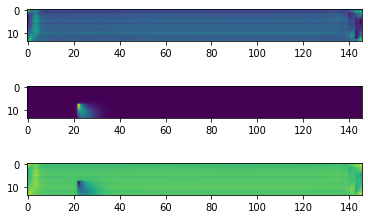

In [16]:
#model.summary()
run=1
predictions = model.predict(tf_dataloader_train) #tf_data_test)
predictions = np.squeeze(predictions)[run]

pred_slice = predictions[8,:,:]
test_slice = df_train_labels.iat[run,0][8,:,:] #df_test_labels
diff_slice = pred_slice - test_slice

#plot slice of predictions
plt.subplot(3,1,1)
plt.imshow(pred_slice.T)
plt.subplot(3,1,2)
plt.imshow(test_slice.T)
plt.subplot(3,1,3)
plt.imshow(diff_slice.T)

# print max min of diff_slice and pred_slice
print(np.max(diff_slice), np.min(diff_slice))
print(np.max(pred_slice), np.min(pred_slice))


In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 18, 146, 14, 8)    23336     
                                                                 
 re_lu_4 (ReLU)              (None, 18, 146, 14, 8)    0         
                                                                 
 conv3d_8 (Conv3D)           (None, 18, 146, 14, 8)    21960     
                                                                 
 re_lu_5 (ReLU)              (None, 18, 146, 14, 8)    0         
                                                                 
 conv3d_9 (Conv3D)           (None, 18, 146, 14, 8)    8008      
                                                                 
 re_lu_6 (ReLU)              (None, 18, 146, 14, 8)    0         
                                                                 
 conv3d_10 (Conv3D)          (None, 18, 146, 14, 16)  

In [ ]:
## plotting

tf_data_train_temp = tf_dataloader_train.take(1)
temp_images, temp_labels = list(tf_data_train_temp)[0]
temp_labels =  temp_labels.numpy()
temp_image =  temp_labels[1]
#print(temp_image.shape)
#plt.imshow(np.squeeze(temp_image[:, :, 0, 0]), cmap="gray")

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of x CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    data = np.flip(np.array(data))
    #data = np.flip(np.array(data),axis=2)
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j]) #, cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 7 rows and 2 columns for 14 slices of the CT scan.
plot_slices(7, 2, 18, 146, temp_image[:, :, :, 0])

# TODO order of z wrong???


In [ ]:
#model = tf.keras.Sequential([
#  tf.keras.layers.Flatten(),
#  tf.keras.layers.Dense(10)
#])
#
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#              metrics=['accuracy'])
#
##model.fit(tf_data_train, epochs=2)

In [ ]:
#width, height, depth=[18,146, 14]
#
#def get_model(width=18, height=146, depth=14):
#    """Build a 3D convolutional neural network model."""
#
#    inputs = tf.keras.Input((width, height, depth, 2)) #2?
#
#    x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
#    x = MaxPool3D(pool_size=2)(x)
#    x = BatchNormalization()(x)
#
#    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
#    x = MaxPool3D(pool_size=2)(x)
#    x = BatchNormalization()(x)
#
#    x = GlobalAveragePooling3D()(x)
#    x = Dense(units=512, activation="relu")(x)
#    x = Dropout(0.3)(x)
#
#    outputs = Dense(units=1, activation="sigmoid")(x)
#
#    # Define the model.
#    model = tf.keras.Model(inputs, outputs, name="3dcnn")
#    return model
#
#
## Build model.
#model = get_model(width=18, height=146, depth=14)
#model.summary()

In [ ]:
###TRY UNET KYLE
def blockUNet(in_c, out_c, input_shape=(18,146,14), transposed=False, bn=True, activation="relu", size=4, strides=2, pad="same", dropout=0.0):
    input_shape = np.append(input_shape, in_c)
    block = Sequential()
    #block.add(tf.keras.Input(input_shape))
    if activation=="relu":
        block.add(ReLU())
    else:
        block.add(LeakyReLU(alpha=0.2))
    if not transposed:
        block.add(Conv3D(out_c, kernel_size=size, strides=strides, padding=pad))
    else:
        block.add(UpSampling3D(size=2, data_format="channels_last"))
        block.add(Conv3D(out_c, kernel_size=(size - 1), strides=1, padding=pad))
    if bn:
        block.add(BatchNormalization(axis=1)) #(out_c))
    if dropout > 0.0:
        block.add(Dropout(dropout)) # inplace=True))
    return block

#UNET Try
channel_exponent = 6
dropout=0.0

channels = int(2**channel_exponent + 0.5)
input_shape = (4, 18, 146, 14, 2) #!! TODO Batchsize!!
model = tf.keras.Sequential([
    Conv3D(filters=channels, kernel_size=4, strides=2, padding="same", use_bias=True,input_shape=input_shape[1:], data_format="channels_last"),
    blockUNet(channels, channels * 2, input_shape[1:-1], transposed=False, bn=True,activation="LeakyReLU",dropout=dropout), #layer2
    #blockUNet(channels * 2, channels * 4, input_shape[1:-1], transposed=False, bn=True,activation="LeakyReLU",dropout=dropout), #layer3
    #blockUNet(channels * 4, channels * 8, input_shape[1:-1], transposed=False, bn=True,activation="LeakyReLU",dropout=dropout, size=4), #layer4
    #blockUNet(channels * 8, channels * 8, input_shape[1:-1], transposed=False, bn=False,activation="LeakyReLU",dropout=dropout, size=2)#, pad="valid"), #layer5
    ])

#TODO : decoder

#model.summary()

# the same model in Keras


In [ ]:
## Compile model.
#initial_learning_rate = 0.0001
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
#)
#model.compile(
#    loss="binary_crossentropy",
#    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
#    metrics=["acc"],
#)
#
## Define callbacks.
#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
#    "3d_image_classification.h5", save_best_only=True
#)
#early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
#
## Train the model, doing validation at the end of each epoch
#epochs = 100
#model.fit(
#    tf_data_train,
#    validation_data=tf_data_test,
#    epochs=epochs,
#    shuffle=True,
#    verbose=2,
#    callbacks=[checkpoint_cb, early_stopping_cb],
#)
#

In [ ]:
#kernel = 3#(3, 3, 3, 1)
#def FCN_model(input_shape=(20,200,16,1), len_classes=5, dropout_rate=0.2, kernel=3):
#
#    input = Input(shape=input_shape) #2D: (None, None, 3))
#    x = Conv3D(filters=32, kernel_size=kernel, strides=1,padding="same")(input) 
#    #  filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
#    x = Dropout(dropout_rate)(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#
#    # x = tf.keras.layers.MaxPooling2D()(x)
#
#    x = Conv3D(filters=64, kernel_size=kernel, strides=1,padding= "same")(x)
#    x = Dropout(dropout_rate)(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#
#    # x = tf.keras.layers.MaxPooling2D()(x)
#
#    x = Conv3D(filters=128, kernel_size=kernel, strides=2)(x)
#    x = Dropout(dropout_rate)(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#
#    # x = tf.keras.layers.MaxPooling2D()(x)
#
#    x = Conv3D(filters=256, kernel_size=kernel, strides=2)(x)
#    x = Dropout(dropout_rate)(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#
#    # x = tf.keras.layers.MaxPooling2D()(x)
#
#    # x = Conv3D(filters=512, kernel_size=kernel, strides=2)(x)
#    # x = Dropout(dropout_rate)(x)
#    # x = BatchNormalization()(x)
#    # x = Activation('relu')(x)
#
#    # Uncomment the below line if you're using dense layers
#    # x = tf.keras.layers.GlobalMaxPooling2D()(x)
#
#    # Fully connected layer 1
#    # x = tf.keras.layers.Dropout(dropout_rate)(x)
#    # x = tf.keras.layers.BatchNormalization()(x)
#    # x = tf.keras.layers.Dense(units=64)(x)
#    # x = tf.keras.layers.Activation('relu')(x)
#
#    # Fully connected layer 1
#    x = Conv3D(filters=64, kernel_size=1, strides=1)(x)
#    x = Dropout(dropout_rate)(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#
#    # Fully connected layer 2
#    # x = tf.keras.layers.Dropout(dropout_rate)(x)
#    # x = tf.keras.layers.BatchNormalization()(x)
#    # x = tf.keras.layers.Dense(units=len_classes)(x)
#    # predictions = tf.keras.layers.Activation('softmax')(x)
#
#    # Fully connected layer 2
#    x = Conv3D(filters=len_classes, kernel_size=1, strides=1)(x)
#    x = Dropout(dropout_rate)(x)
#    x = BatchNormalization()(x)
#    #x = GlobalMaxPooling3D()(x) #TODO I PERSONALLY EXCLUDED - BACK IN?
#    predictions = Activation('softmax')(x)
#
#    model = tensorflow.keras.Model(inputs=input, outputs=predictions)
#    
#    print(model.summary())
#    print(f'Total number of layers: {len(model.layers)}')
#
#    return model
#
#model = FCN_model(input_shape=(20, 200, 16, 1), len_classes=5, dropout_rate=0.2)